In [1]:
# Step 1: Import Libraries
import pandas as pd  # Pandas for data manipulation
import numpy as np  # NumPy for numerical operations
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF and PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose  # Seasonal decomposition
from pmdarima import auto_arima  # Auto ARIMA model selection
from matplotlib import pyplot as plt  # Matplotlib for plotting
from statsmodels.tools.eval_measures import mse, rmse  # Evaluation metrics
from sklearn.model_selection import train_test_split  # Train-test split
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF for multicollinearity
from sklearn.metrics import mean_absolute_error  # MAE for model evaluation
from sklearn.metrics import mean_squared_error  # MSE for model evaluation
import seaborn as sns

In [2]:
# Use the date_format argument in read_csv
df = pd.read_csv('walmart.csv', parse_dates=['Date'], date_format='%d/%m/%y', dayfirst=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Resample to weekly frequency starting on Sundays
df = df.resample('W-SUN').mean()  

In [3]:
df.reset_index(inplace=True)

In [4]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Store         143 non-null    float64       
 2   Weekly_Sales  143 non-null    float64       
 3   Holiday_Flag  143 non-null    float64       
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 9.1 KB


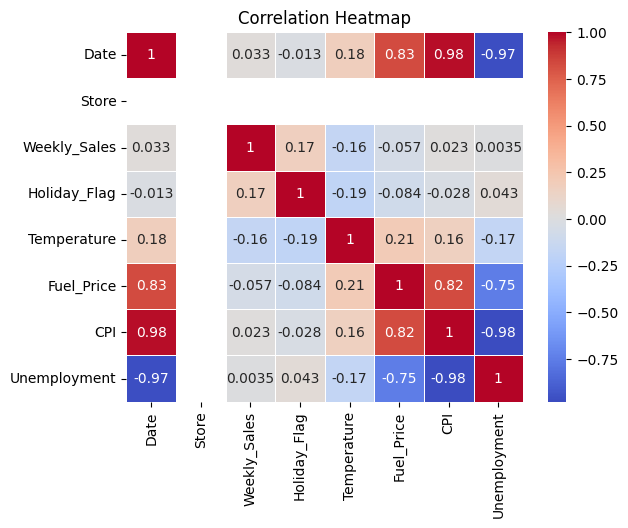

In [5]:
# Correlation heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

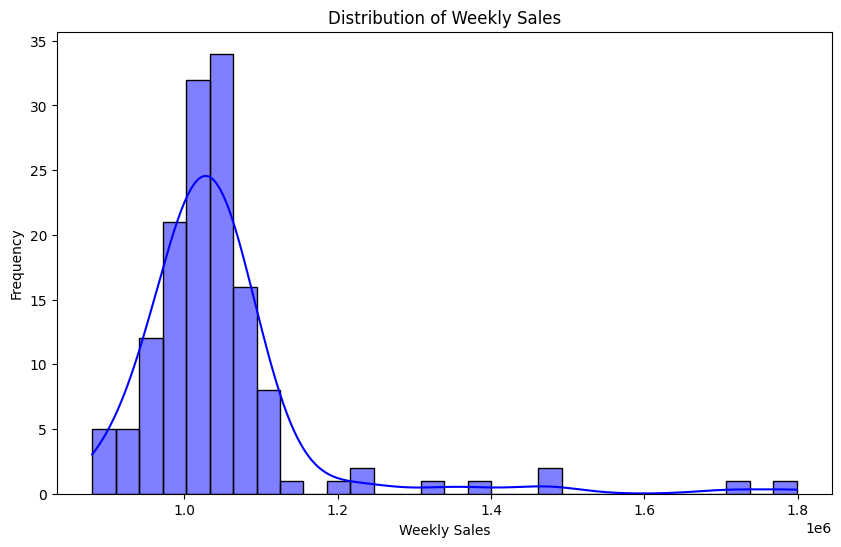

In [6]:
# Distribution of a specific column (e.g., 'Weekly_Sales')
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

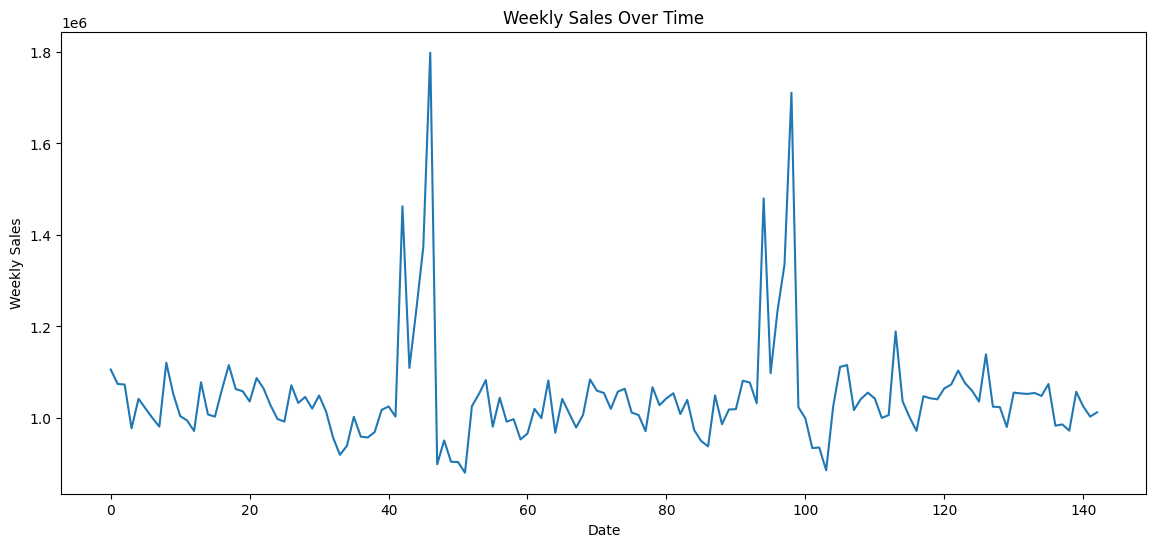

In [7]:
# Step 5: Time Series Plot
# Assuming 'Date' is the index column
plt.figure(figsize=(14, 6))
df['Weekly_Sales'].plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

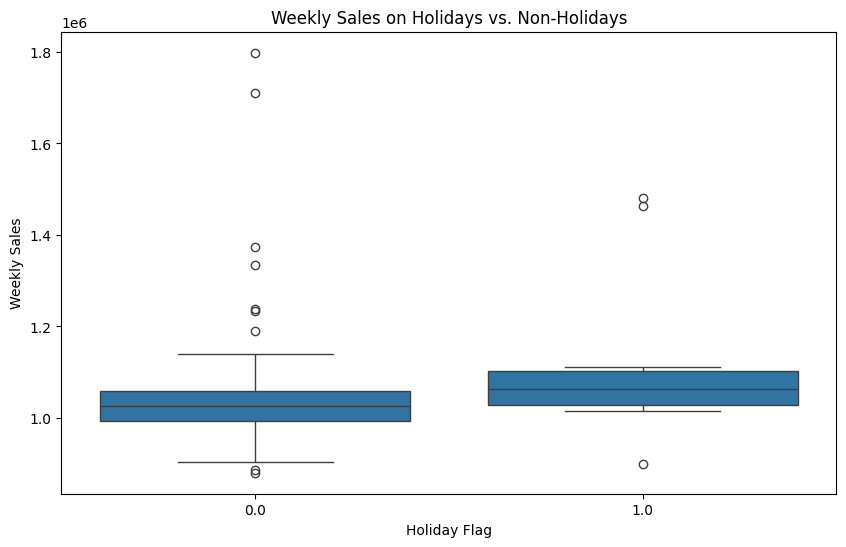

In [8]:
# Boxplot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Weekly Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.show()

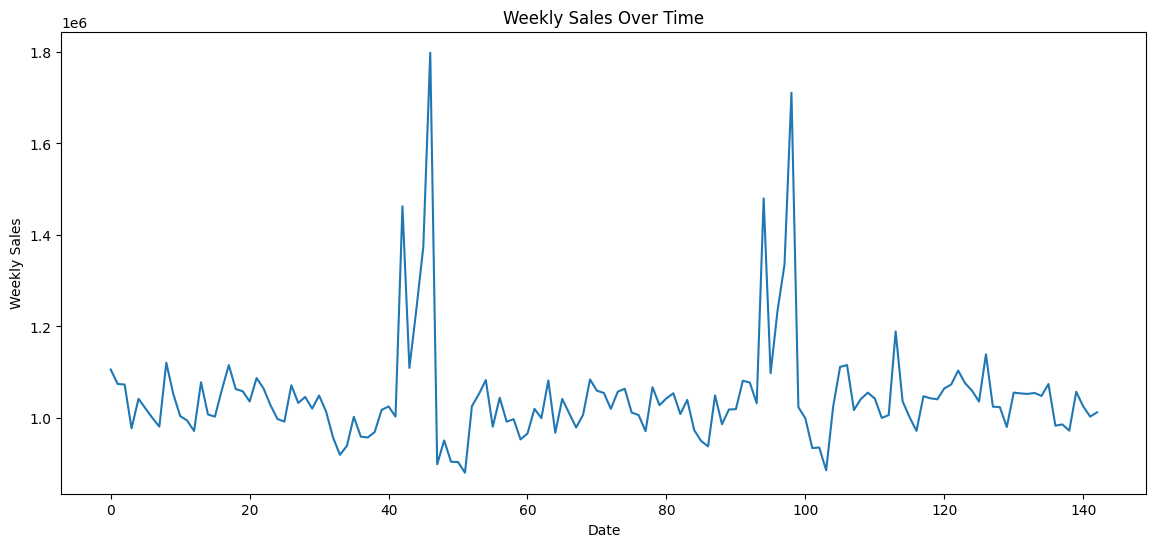

In [9]:
# Step 5: Time Series Plot
# Assuming 'Date' is the index column
plt.figure(figsize=(14, 6))
df['Weekly_Sales'].plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [10]:
print(df.columns)

Index(['Date', 'Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')


In [11]:
df.set_index('Date', inplace=True)

In [12]:
df = df.asfreq('W-SUN')  

In [13]:
df = df.sort_index()

In [14]:

train_size = int(len(df) * 0.8)  # 80% for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [15]:
 #Choose external factors for exogenous variables
exog_train = train[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
exog_test = test[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

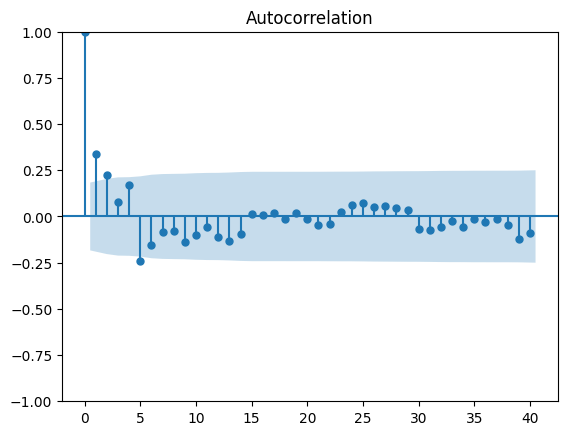

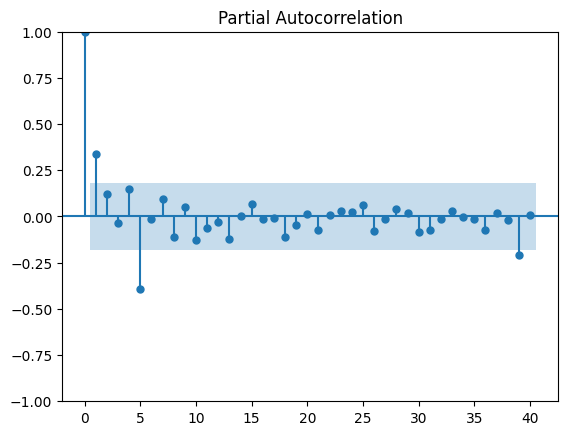

In [16]:

# Plot ACF and PACF
plot_acf(train['Weekly_Sales'], lags=40)
plot_pacf(train['Weekly_Sales'], lags=40)
plt.show()


In [17]:
# Create SARIMAX model with reduced complexity
order = (1, 0, 1)  # Adjust the order as needed
seasonal_order = (0, 0, 0, 0)  # No seasonal ARMA components initially
model = SARIMAX(train['Weekly_Sales'], exog=exog_train, order=order, seasonal_order=seasonal_order, enforce_invertibility=False)

# Fit the model
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31438D+01    |proj g|=  1.00591D-02

At iterate    5    f=  1.31437D+01    |proj g|=  2.99707D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5      9      1     0     0   2.997D-06   1.314D+01
  F =   13.143685765345250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [24]:
# Assuming you want to forecast 10 weeks into the future
forecast_horizon = 10

# Get the last date in your original data
last_date = df.index[-1]

# Generate future dates
extended_dates_exog = pd.date_range(last_date, periods=forecast_horizon + 1, freq='W-SUN')[1:]

# Create a DataFrame with the extended dates
extended_dates_df = pd.DataFrame(index=extended_dates_exog)

In [25]:
# Concatenate Exog DataFrames
exog_test_extended = pd.concat([exog_test, extended_dates_df], axis=1)

# Handle Missing Values (if needed)
exog_test_extended = exog_test_extended.fillna(exog_test_extended.mean())

# Forecast
forecast = results.get_forecast(steps=len(exog_test_extended), exog=exog_test_extended)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

In [ ]:
forecast = results.get_forecast(steps=len(exog_test_extended), exog=exog_test_extended)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

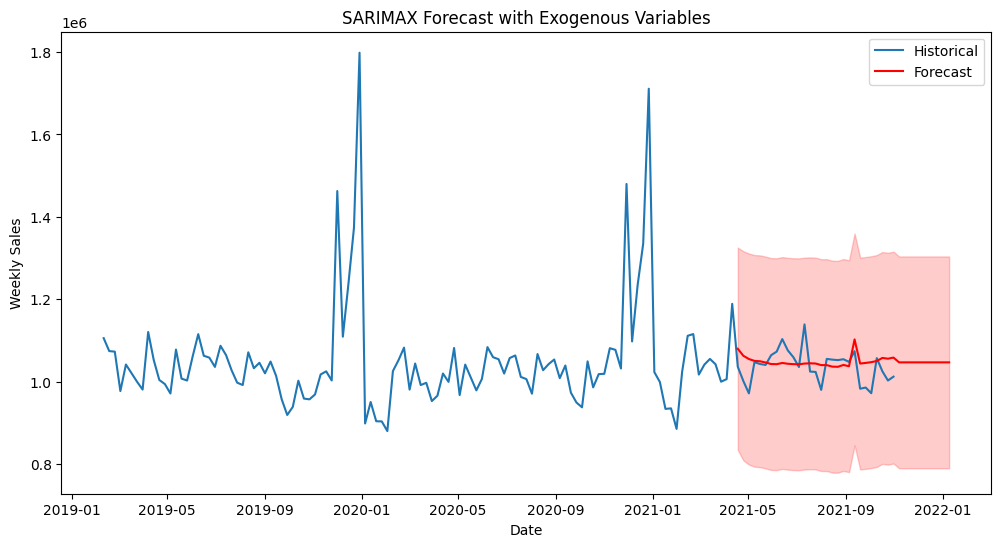

In [26]:

# Plot the results including the forecasted future
plt.figure(figsize=(12, 6))
plt.plot(df['Weekly_Sales'], label='Historical')
plt.plot(mean_forecast.index, mean_forecast.values, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Align mean_forecast with the length of test['Weekly_Sales']
mean_forecast_aligned = mean_forecast.values[:len(test['Weekly_Sales'])]

# Combine forecast and actual values for scaling
combined_values = np.vstack((test['Weekly_Sales'].values, mean_forecast_aligned))

# Use MinMaxScaler to scale the combined values
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(combined_values.T)  # Transpose to have samples in rows

# Extract scaled forecast and actual values
scaled_actual = scaled_values[:, 0]
scaled_forecast = scaled_values[:, 1]

# Calculate scaled metrics
scaled_mse = mean_squared_error(scaled_actual, scaled_forecast)
scaled_rmse = np.sqrt(scaled_mse)
scaled_mae = mean_absolute_error(scaled_actual, scaled_forecast)

print(f"Scaled Mean Squared Error (MSE): {scaled_mse:.6f}")
print(f"Scaled Root Mean Squared Error (RMSE): {scaled_rmse:.6f}")
print(f"Scaled Mean Absolute Error (MAE): {scaled_mae:.6f}")

Scaled Mean Squared Error (MSE): 0.136800
Scaled Root Mean Squared Error (RMSE): 0.369865
Scaled Mean Absolute Error (MAE): 0.311933
